<a href="https://colab.research.google.com/github/Stan081/ML/blob/main/Malaria_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
# Load dataset from tensorflow dataset repo. Also shuffle the dataset to add a level of randomness to it.
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [3]:
dataset
# The tfds.load method returns a list for the dataset which contains other elements aside the actual dataset, so to get the actual dataset, we take the first element in the list
dataset = dataset[0]

In [4]:
# Perform a split on the dataset to get train, validation and test dataset.
def dataset_split(dataset:list, train_ratio, validation_ratio):
  '''
    input:
      dataset : list of data items (images)
      train_ratio, validation_ratio are decimal values which show the percentage of the dataset to be taken.

    returns:
      train_data : set split for training purpose.
      validation_split : set split for validation purpose.
      test_split : set split for testing purpose.
  '''
  # Get the size of the entire dataset
  dataset_size = len(dataset)

  # Take first percentage of the data
  train_data = dataset.take(int(train_ratio * dataset_size))

  # skip the already taken data
  val_test_split = dataset.skip(int(train_ratio * dataset_size))

  #Take the next percentage of the left over data after first split
  validation_data = val_test_split.take(int(validation_ratio * dataset_size))

  # Take the remainder for test
  test_data = val_test_split.skip(int(validation_ratio * dataset_size))

  return train_data, validation_data, test_data

In [5]:
train_set, validation_set, test_set = dataset_split(dataset, 0.7, 0.2)

VISUALIZING THE DATA.

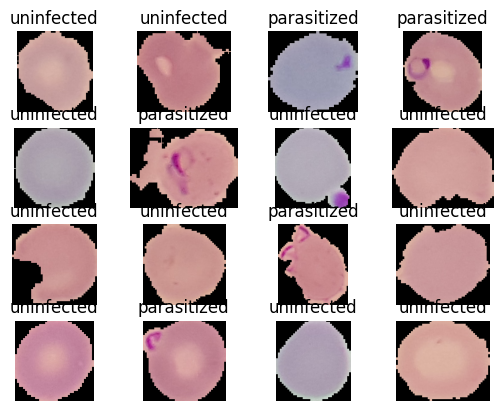

In [6]:
for i, (image, label) in enumerate(validation_set.take(16)):
  ax = plt.subplot(4,4,i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

PROCESSING

In [7]:
size = 224
def resize_and_rescale(image, label):
  """
    The method takes an image and resizes it to the desired dimension and the rescales the pixel values of the image to range from 0 to 1 instead of 0 to 255
    input:
      image: image to be resized
      label: label of the image
      size: dimension of the image (size X size)
    returns:
      Resized image and the label
  """
  return tf.image.resize(image, (size, size))/255.0, label

In [8]:
train_set = train_set.map(resize_and_rescale)
validation_set = validation_set.map(resize_and_rescale)
test_set = test_set.map(resize_and_rescale)

In [9]:
for (image, label) in train_set.take(1):
  print (image, dataset_info.features['label'].int2str(label) )

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) uninfected


In [10]:
train_set = train_set.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
validation_set = validation_set.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Model Creation

In [11]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (size, size, 3)),

    Conv2D(filters=16, kernel_size=3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(1000, activation='relu'),
    BatchNormalization(),
    Dense(1000, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),

])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      2320      
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [13]:
model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics='accuracy')

In [14]:
history = model.fit(train_set, validation_data = validation_set, epochs=15, verbose=1)

Epoch 1/15
603/603 [==============================] - 52s 73ms/step - loss: 0.3472 - accuracy: 0.8830 - val_loss: 0.4336 - val_accuracy: 0.8643
Epoch 2/15
603/603 [==============================] - 50s 83ms/step - loss: 0.1990 - accuracy: 0.9359 - val_loss: 0.3237 - val_accuracy: 0.9374
Epoch 3/15
603/603 [==============================] - 45s 75ms/step - loss: 0.1785 - accuracy: 0.9427 - val_loss: 1.3784 - val_accuracy: 0.5035
Epoch 4/15
603/603 [==============================] - 47s 79ms/step - loss: 0.1556 - accuracy: 0.9510 - val_loss: 0.3817 - val_accuracy: 0.8755
Epoch 5/15
603/603 [==============================] - 44s 73ms/step - loss: 0.1469 - accuracy: 0.9537 - val_loss: 3.0030 - val_accuracy: 0.8492
Epoch 6/15
603/603 [==============================] - 45s 75ms/step - loss: 0.1524 - accuracy: 0.9505 - val_loss: 0.1665 - val_accuracy: 0.9581
Epoch 7/15
603/603 [==============================] - 45s 75ms/step - loss: 0.1291 - accuracy: 0.9594 - val_loss: 0.1899 - val_accuracy:

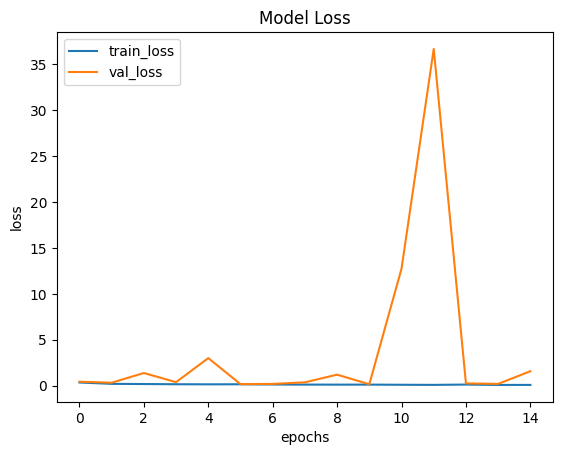

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

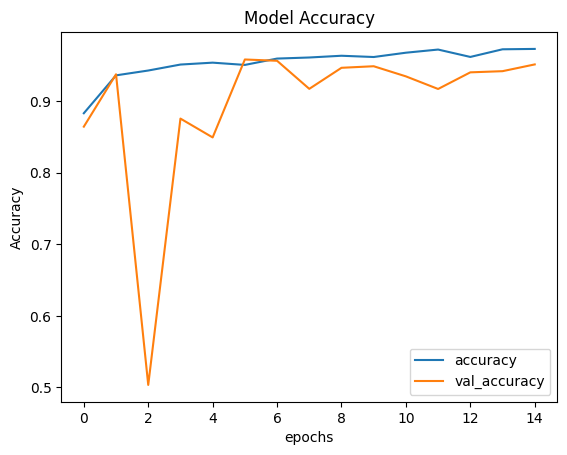

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [17]:
test_set = test_set.batch(5)


In [18]:
test_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
model.evaluate(test_set)

552/552 [==============================] - 16s 6ms/step - loss: 2.1401 - accuracy: 0.9441


[2.140078544616699, 0.9441421627998352]

In [20]:
def cell_state(x):
  if(x < 0.7):
    return str('P')
  else:
    return str('U')

In [21]:
cell_state(model.predict(test_set.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'U'

In [22]:
model.predict(test_set.take(1))

1/1 [==============================] - 12s 12s/step


array([[4.26511467e-03],
       [4.95993649e-04],
       [4.81791832e-02],
       [1.03531565e-04],
       [9.84467030e-01]], dtype=float32)

1/1 [==============================] - 0s 19ms/step


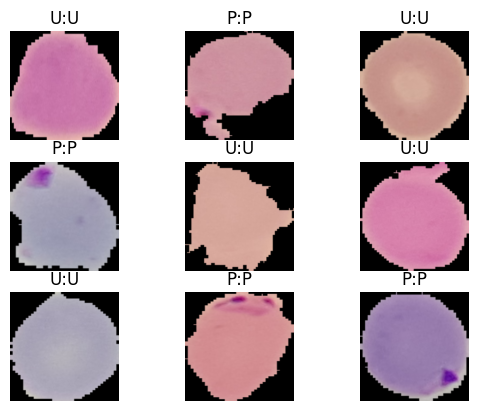

In [23]:
for i, (image, label) in enumerate(test_set.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(cell_state(label.numpy()[0])) + ':' + str(cell_state(model.predict(image)[0][0])))
  plt.axis('off')

In [26]:
mal_model = model.save("models/malaria_model/")